In [1]:
print("hello")

hello


In [2]:
import time
from pprint import pprint
from IPython.display import display
from glob import glob
import re
import math
import random
import os
print("hello1")
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print("hello2")
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
print("hello3")
import torch
torch.set_default_dtype(torch.float64)
import torch_geometric as tg
print("hello4")
import e3nn
print("hello5")
import e3nn.point.data_helpers as dh 
from e3nn.point.message_passing import Convolution
from training_utils import Stopwatch, model_from_kwargs, save_model
from variable_networks import VariableParityNetwork
print("hello6")
import read_utilities
from read_utilities import read_molecule_data
from diagnostics import *
print("bye")

hello1
hello2
hello3
hello4
hello5
hello6
bye


In [3]:
# make sure CUDA is available
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.version.cuda)
#print(torch.cuda.memory_summary())
device = "cuda"
torch.rand(10).to(device)
#torch.rand(10, device=device)

0
1
Tesla V100-PCIE-32GB
True
10.1


tensor([0.2172, 0.8780, 0.2139, 0.1502, 0.0330, 0.8337, 0.1646, 0.5150, 0.0789,
        0.3061], device='cuda:0')

In [4]:
filenames = sorted(glob("data/qm7_*.hdf5"))
molecules_dict = read_molecule_data(filenames, max_molecules=None)
molecules = list(molecules_dict.values())

Reading data from data/qm7_0.hdf5...
Done!  720 molecules and 72000 training examples read so far.

Reading data from data/qm7_1.hdf5...
Done!  1440 molecules and 144000 training examples read so far.

Reading data from data/qm7_2.hdf5...
Done!  2160 molecules and 216000 training examples read so far.

Reading data from data/qm7_3.hdf5...
Done!  2880 molecules and 288000 training examples read so far.

Reading data from data/qm7_4.hdf5...
Done!  3600 molecules and 360000 training examples read so far.

Reading data from data/qm7_5.hdf5...
Done!  4320 molecules and 432000 training examples read so far.

Reading data from data/qm7_6.hdf5...
Done!  5035 molecules and 503500 training examples read so far.

Reading data from data/qm7_7.hdf5...
Done!  5745 molecules and 574500 training examples read so far.

Reading data from data/qm7_8.hdf5...
Done!  6455 molecules and 645500 training examples read so far.

Reading data from data/qm7_9.hdf5...
Done!  7165 molecules and 716500 training examp

In [5]:
relevant_elements = read_utilities.relevant_elements
n_elements = read_utilities.n_elements
n_molecules = len(molecules)

carbon
n=3576100  mean=0.0258 stdev=0.9964


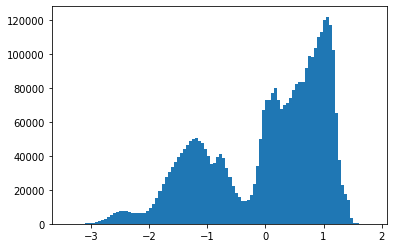

proton
n=6195900  mean=-0.0657  stdev=1.0506


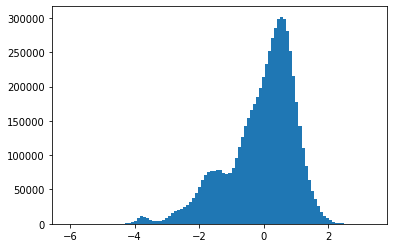

In [6]:
# get stats
all_shieldings = {}
for molecule in molecules:
    atomic_symbols = molecule.atomic_symbols
    perturbed_shieldings = molecule.perturbed_shieldings
    for i,symbol in enumerate(atomic_symbols):
        if symbol in relevant_elements:
            if symbol not in all_shieldings:
                all_shieldings[symbol] = []
            shieldings_list = all_shieldings[symbol]
            current_shieldings = shieldings_list.extend(perturbed_shieldings[:,i])
shieldingsC = all_shieldings["C"]
print("carbon")
print(f"n={len(shieldingsC)}  mean={np.mean(shieldingsC):.4f} stdev={np.std(shieldingsC):.4f}")
plt.hist(shieldingsC,bins=100)
plt.show()

shieldingsH = all_shieldings["H"]
print("proton")
print(f"n={len(shieldingsH)}  mean={np.mean(shieldingsH):.4f}  stdev={np.std(shieldingsH):.4f}")
plt.hist(shieldingsH,bins=100)
plt.show()

In [7]:
# features are one-hots for every atom,
# so this is (number of one_hots, rank zero tensor, even parity)
Rs_in = [(n_elements,0,1)]

# we are outputing one scalar for every atom
# so this is (one, rank zero tensor, even parity)
Rs_out = [(1,0,1)]

# maximum extent of radial basis functions in Angstroms
max_radius = 5.0

In [8]:
# generate random iteration order for dataset
print("Generating random indices...", end='')
seed = 1
shuffler = random.Random(seed)
dataset_iteration_indices = []
for i in range(n_molecules):
    n_examples = len(molecules[i].perturbed_geometries)
    for j in range(n_examples):
        this_example = i,j
        dataset_iteration_indices.append(this_example)
shuffler.shuffle(dataset_iteration_indices)
n_total_examples = len(dataset_iteration_indices)
print("done!")

Generating random indices...done!


In [9]:
# create torch object for a single training example
def get_data_neighbors(i,j):
    molecule = molecules[i]
    features = torch.tensor(molecule.features, dtype=torch.float64)
    weights = torch.tensor(molecule.weights, dtype=torch.float64)
    g = torch.tensor(molecule.perturbed_geometries[j,:,:], dtype=torch.float64)
    s = torch.tensor(molecule.perturbed_shieldings[j], dtype=torch.float64).unsqueeze(-1)  # [1,N]
    data = dh.DataNeighbors(x=features, Rs_in=Rs_in, pos=g, r_max=max_radius,
                            self_interaction=True, name=molecule.name,
                            weights=weights, y=s, Rs_out = Rs_out)
    return data

In [10]:
# max is 716500
test_size = 50000
train_size = 666500
assert train_size + test_size <= n_total_examples
batch_size = 50
training_megabatch_size = 50000  # number of training examples to load into memory at a time 

In [11]:
# function from creating training dataset from dataset_iteration_indices[h_min:h_max]
def make_megabatch(h_min, h_max):
    return_list = []
    time1 = time.time()
    n_examples_to_process = h_max - h_min
    for h in range(h_min, h_max):
        if h == h_min or (h+1) % 100 == 0 or h_max == n_examples_to_process - 1:
            print(f"Processing example {h-h_min+1:6d}/{n_examples_to_process:6d}...           ", end='\r', flush=True)
        i,j = dataset_iteration_indices[h]
        data = get_data_neighbors(i,j)
        return_list.append(data)
    time2 = time.time()
    print(f"\nDone pre-processing data!  Operation took {time2-time1:.1f} s.")    
    return return_list

def load_dataset(filename, silent=False):
    file_size = os.path.getsize(filename) / 1000000
    if not silent:
        print(f"Loading precomputed vectors from {filename} ({file_size:.1f} MB)...", end='')
    time1 = time.time()
    data_list = torch.load(filename)
    time2 = time.time()
    if not silent:
        print(f"done!  Took {time2-time1:.1f} s.")  
    return data_list

In [12]:
# load testing data into memory
filename = "preprocessed/qm7-preprocessed-test_set.torch"
if os.path.isfile(filename):
    testing_data_list = load_dataset(filename)
else:
    testing_data_list = make_megabatch(0, test_size)
    time1 = time.time()
    print(f"Saving to {filename}...", end='', flush=True)
    torch.save(testing_data_list, filename)
    file_size = os.path.getsize(filename) / 1000000
    time2 = time.time()
    print(f"done!  Took {time2-time1:.1f} s.  File occupies {file_size:.1f} MB.")

Loading precomputed vectors from preprocessed/qm7-preprocessed-test_set.torch (551.3 MB)...done!  Took 8.7 s.


In [13]:
# preprocess training data and save to disk
n_megabatches = 0
for megabatch_index,h_min in enumerate(range(test_size, test_size+train_size, training_megabatch_size)):
    n_megabatches += 1
    h_max = min(h_min + min(train_size,training_megabatch_size), n_total_examples)
    filename = f"preprocessed/qm7-preprocessed-training_set-batch_{megabatch_index:02d}.torch"
    print(f"Megabatch {megabatch_index+1}: indices {h_min}-{h_max}")
    if os.path.isfile(filename):
        print(f"{filename} already exists, so skipping pre-processing.\n")
    else:
        data_list = make_megabatch(h_min, h_max)
        time1 = time.time()
        print(f"Saving to {filename}...", end='', flush=True)
        torch.save(data_list, filename)
        file_size = os.path.getsize(filename) / 1000000
        time2 = time.time()
        print(f"done!  Took {time2-time1:.1f} s to save.  File occupies {file_size:.1f} MB.\n")

Megabatch 1: indices 50000-100000
preprocessed/qm7-preprocessed-training_set-batch_00.torch already exists, so skipping pre-processing.

Megabatch 2: indices 100000-150000
preprocessed/qm7-preprocessed-training_set-batch_01.torch already exists, so skipping pre-processing.

Megabatch 3: indices 150000-200000
preprocessed/qm7-preprocessed-training_set-batch_02.torch already exists, so skipping pre-processing.

Megabatch 4: indices 200000-250000
preprocessed/qm7-preprocessed-training_set-batch_03.torch already exists, so skipping pre-processing.

Megabatch 5: indices 250000-300000
preprocessed/qm7-preprocessed-training_set-batch_04.torch already exists, so skipping pre-processing.

Megabatch 6: indices 300000-350000
preprocessed/qm7-preprocessed-training_set-batch_05.torch already exists, so skipping pre-processing.

Megabatch 7: indices 350000-400000
preprocessed/qm7-preprocessed-training_set-batch_06.torch already exists, so skipping pre-processing.

Megabatch 8: indices 400000-450000


In [14]:
# mean-squared loss (not RMS!)
def loss_function(output, data):
    predictions = output
    observations = data.y
    weights = data.weights
    normalization = weights.sum()
    residuals = (predictions-observations)
    loss = residuals.square() * weights
    loss = loss.sum() / normalization
    return loss, residuals

In [66]:
# model_kwargs = {
#     'Rs_in': Rs_in,            # shape of inputs
#     'Rs_out': Rs_out,          # shape of outputs
#     'muls': [3,4,5,6],            # how many copies of each tensor at each layer
#     'lmaxes': [4,3,2,1],          # maximum angular momentum
#     'max_radius': max_radius,  # radial kernel will extend out this far
#     'number_of_basis': 50,     # number of Gaussians in radial kernel?
# }
# model = VariableParityNetwork(convolution=Convolution, **model_kwargs)
# model.to(device);

In [22]:
# load previously trained model
model_dict = torch.load("data/qm7-mul3456-lmax4321-model1.torch")
model_kwargs = model_dict['model_kwargs']
model = VariableParityNetwork(convolution=Convolution, **model_kwargs)
model.load_state_dict(model_dict['state_dict'])
model.to(device)
print("Loaded model.")

Loaded model.


In [23]:
# training parameters
learning_rate = 3e-3
opt = torch.optim.Adam(model.parameters(), learning_rate)
opt.load_state_dict(model_dict["optimizer_state_dict"])   # can only use learning_rate from file!
print(opt)
epochs = 100       
n_norm = 14           # n_norm is average number of convolution neighbors per atom
batch_size = 100

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [24]:
# prepare to train model
dataset_iteration_indices = None
torch.cuda.empty_cache()

testing_size = len(testing_data_list)
n_testing_batches = math.ceil(testing_size / batch_size)
testing_dataloader = tg.data.DataListLoader(testing_data_list, batch_size=batch_size, shuffle=False)

results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
history = []      # index is epoch, items are (train_loss, test_loss)

In [25]:
def save_model(model_kwargs, model, filename, optimizer=None):
    model_dict = {
        'state_dict': model.state_dict(),
        'model_kwargs': model_kwargs
    }
    if optimizer is not None:
        model_dict['optimizer_state_dict'] = optimizer.state_dict()
    torch.save(model_dict, filename)

In [ ]:
# train model
all_stopwatch = Stopwatch(running=True)
for epoch in range(epochs):
    epoch_stopwatch = Stopwatch(running=False)
    
    # training
    training_loss_this_epoch = 0.0
    n_examples_seen_this_epoch = 0
    for megabatch_index in range(n_megabatches):
        # load data from this megabatch and shuffle it
        if megabatch_index > 0:
            print()
        print("Loading...", end='', flush=True)
        filename = f"preprocessed/qm7-preprocessed-training_set-batch_{megabatch_index:02d}.torch"
        data_list = load_dataset(filename, silent=True)
        n_examples_this_megabatch = len(data_list)
        shuffler = random.Random(epoch)  # set seed to epoch index
        shuffler.shuffle(data_list)      # allows deterministic shuffling
        training_dataloader = tg.data.DataListLoader(data_list, batch_size=batch_size, shuffle=False)
        
        # train on this megabatch in minibatches
        n_minibatches = math.ceil(n_examples_this_megabatch/batch_size)
        epoch_stopwatch.start()
        for minibatch_index,data in enumerate(training_dataloader):
            # forward pass
            n_examples_this_minibatch = len(data)

            data = tg.data.Batch.from_data_list(data)
            data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
            loss, residuals = loss_function(output, data)

            # backward pass
            opt.zero_grad()
            loss.backward()
            opt.step()

            # clean up
            del data
            
            # update training loss
            minibatch_loss = np.sqrt(loss.item())
            training_loss_this_epoch = training_loss_this_epoch * n_examples_seen_this_epoch + \
                                       minibatch_loss * n_examples_this_minibatch
            n_examples_seen_this_epoch += n_examples_this_minibatch
            training_loss_this_epoch = training_loss_this_epoch / n_examples_seen_this_epoch
            
            # print update
            print(f"\rEpoch {epoch+1:<4d}   Megabatch {megabatch_index+1:>2d}      train {minibatch_index+1:5d} / {n_minibatches:5d}  loss = {minibatch_loss:12.3f}    cum_loss = {training_loss_this_epoch:12.3f}            ", end="\r", flush=True)
        epoch_stopwatch.stop()
        
    epoch_stopwatch.start()
    
    # testing
    print()
    n_minibatches = math.ceil(test_size/batch_size)
    testing_loss = 0.0
    n_testing_examples_seen = 0
    for minibatch_index,data in enumerate(testing_dataloader):
        n_examples_this_minibatch = len(data)
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        
        with torch.no_grad():
            # run model
            output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)

            # compute MSE
            loss, residuals = loss_function(output,data)
            minibatch_loss = np.sqrt(loss.item())
            testing_loss = testing_loss * n_testing_examples_seen + \
                           minibatch_loss * n_examples_this_minibatch
            n_testing_examples_seen += n_examples_this_minibatch
            testing_loss = testing_loss / n_testing_examples_seen

        del data
        print(f"Epoch {epoch+1:<4d}    test {minibatch_index+1:5d} / {n_minibatches:5d}  loss = {testing_loss:12.3f}                                           ", end="\r", flush=True)
    
    epoch_stopwatch.stop()
    epoch_elapsed_time = epoch_stopwatch.get_elapsed()
    total_elapsed_time = all_stopwatch.get_elapsed()
    history.append((training_loss_this_epoch, testing_loss))
    
    print("\nCheckpointing...", end='\r', flush=True)
    model_filename = f"checkpoints/qm7-mul3456-lmax4321-epoch-{epoch+1:03d}.torch"
    save_model(model_kwargs, model, model_filename, optimizer=opt)
    
    print(f"Epoch {epoch+1:<4d}   training = {training_loss_this_epoch:<12.3f}    testing = {testing_loss:<12.3f}     elapsed = {epoch_elapsed_time:<.2f} s        total = {total_elapsed_time:<.2f} s")
    print()

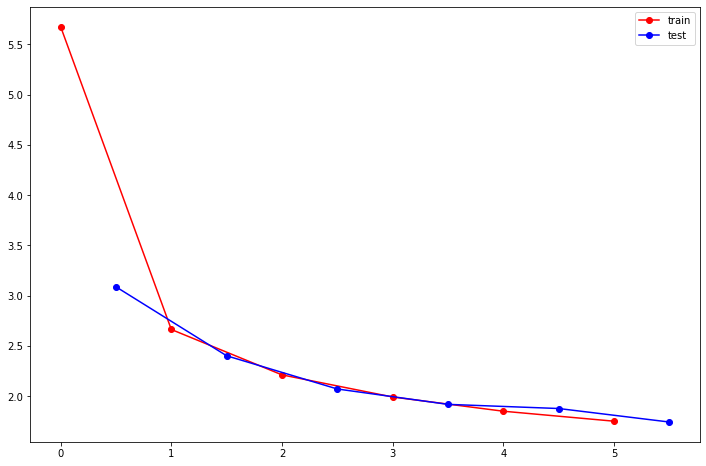

In [27]:
# plot learning curve
plt.figure(figsize=(12,8))
epoch = list(range(len(history)))
epoch = np.array(epoch)
epoch2 = epoch + 0.5
training_loss = [ training for training,testing in history ]
testing_loss = [ testing for training,testing in history ]
plt.plot(epoch, training_loss, "ro-", label="train")
plt.plot(epoch2, testing_loss, "bo-", label="test")
plt.legend(loc="best")
plt.show()

In [36]:
# compute testing loss
results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
n_minibatches = math.ceil(test_size/batch_size)
testing_loss = 0.0
n_testing_examples_seen = 0
testing_stopwatch = Stopwatch(running=True)
for minibatch_index,data in enumerate(testing_dataloader):
    n_examples_this_minibatch = len(data)
    data = tg.data.Batch.from_data_list(data)
    data.to(device)

    with torch.no_grad():
        # run model
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)

        # compute MSE
        loss, residuals = loss_function(output,data)
        minibatch_loss = np.sqrt(loss.item())
        testing_loss = testing_loss * n_testing_examples_seen + \
                       minibatch_loss * n_examples_this_minibatch
        n_testing_examples_seen += n_examples_this_minibatch
        testing_loss = testing_loss / n_testing_examples_seen

        # rescale residuals back to ppm and store
        residuals = residuals.squeeze(-1).cpu().numpy()
        i=0
        for name in data.name:
            molecule = molecules_dict[name]
            n_atoms = molecule.n_atoms
            scaling_factors = molecule.scaling_factors
            if name not in results_dict:
                results_dict[name] = []
            subset = residuals[i:i+n_atoms] * scaling_factors[:,1]
            results_dict[name].append(subset)
            i += n_atoms
        
    del data
    print(f"test {minibatch_index+1:5d} / {n_minibatches:5d}       minibatch loss = {minibatch_loss:<12.3f}   overall loss = {testing_loss:<12.3f}                                        ", end="\r", flush=True)
testing_stopwatch.stop()
print(f"\nOverall loss is {testing_loss.item():.3f}.  Evaluation took {testing_stopwatch.get_elapsed():.2f} s.")

test   500 /   500       minibatch loss = 1.738          overall loss = 1.698                                               
Overall loss is 1.698034.  Evaluation took 87.05 s.


In [37]:
# results_dict : molecule name -> residuals (n_examples,n_atoms)
# results_dict2 : site label -> residuals
results_dict2 = {}
all_residuals = {}  # element --> [residuals]
for name,results in results_dict.items():
    results = np.array(results).T
    molecule = molecules_dict[name]
    atomic_symbols = molecule.atomic_symbols
    for atomic_index,this_result in enumerate(results):
        element = atomic_symbols[atomic_index]
        if element not in relevant_elements:
            continue
        label = f"{name}_{element}{atomic_index+1}"
        results_dict2[label]=this_result
        if element not in all_residuals:
            all_residuals[element] = []
        all_residuals[element].extend(this_result)

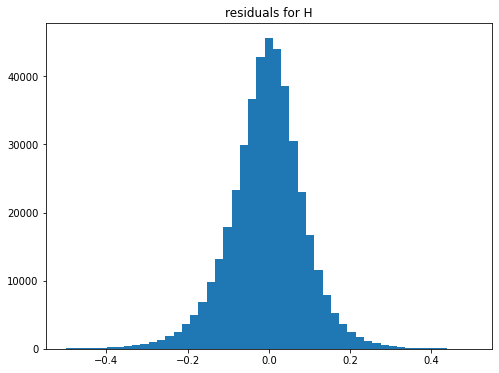

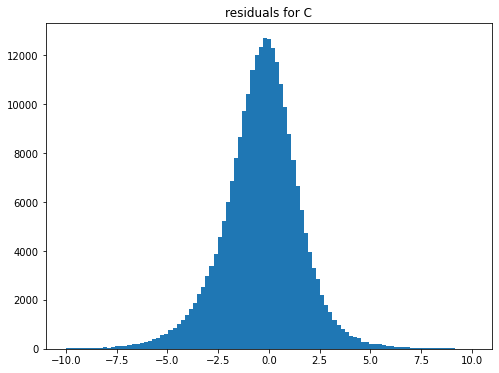

In [39]:
e="H"
bins = np.linspace(-0.5,0.5,50)
plt.figure(figsize=(8,6))
plt.title(f"residuals for {e}")
plt.hist(all_residuals[e],bins=bins)
plt.show()
e="C"
bins = np.linspace(-10,10,100)
plt.figure(figsize=(8,6))
plt.title(f"residuals for {e}")
plt.hist(all_residuals[e],bins=bins)
plt.show()

In [40]:
# get stats on everything
for e in relevant_elements:
    mean_error = np.mean(all_residuals[e])
    RMSE = np.sqrt(np.mean(np.square(all_residuals[e])))
    min_err = np.min(all_residuals[e])
    max_err = np.max(all_residuals[e])
    print(f"{e}:  mean ={mean_error:7.3f}  RMSE ={RMSE:7.3f}   range = {min_err:7.2f} to {max_err:7.2f}")

C:  mean = -0.357  RMSE =  1.964   range =  -21.68 to   17.41
H:  mean = -0.005  RMSE =  0.096   range =   -1.06 to    1.12


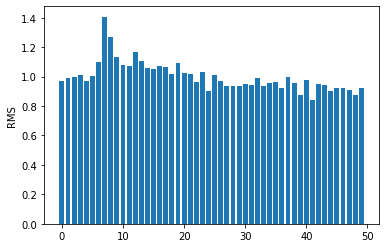

In [41]:
show_radial_parameters(model, max_radius)

In [64]:
print_parameter_size(model)

layers.0.0.kernel.R.f.weights.0: [100, 50]
layers.0.0.kernel.R.f.weights.1: [100, 100]
layers.0.0.kernel.R.f.weights.2: [100, 100]
layers.0.0.kernel.R.f.weights.3: [135, 100]
layers.0.0.kernel.linear.weight: [75]
layers.1.0.kernel.R.f.weights.0: [100, 50]
layers.1.0.kernel.R.f.weights.1: [100, 100]
layers.1.0.kernel.R.f.weights.2: [100, 100]
layers.1.0.kernel.R.f.weights.3: [768, 100]
layers.1.0.kernel.linear.weight: [120]
layers.2.0.kernel.R.f.weights.0: [100, 50]
layers.2.0.kernel.R.f.weights.1: [100, 100]
layers.2.0.kernel.R.f.weights.2: [100, 100]
layers.2.0.kernel.R.f.weights.3: [1260, 100]
layers.2.0.kernel.linear.weight: [252]
layers.3.0.kernel.R.f.weights.0: [100, 50]
layers.3.0.kernel.R.f.weights.1: [100, 100]
layers.3.0.kernel.R.f.weights.2: [100, 100]
layers.3.0.kernel.R.f.weights.3: [1232, 100]
layers.3.0.kernel.linear.weight: [462]
layers.4.kernel.R.f.weights.0: [100, 50]
layers.4.kernel.R.f.weights.1: [100, 100]
layers.4.kernel.R.f.weights.2: [100, 100]
layers.4.kernel.R.

In [65]:
def count_parameters(model):
    model_count_dict = {} # layer # -> n_params
    n_total_parameters = 0
    for name, param in model.named_parameters():
        n_params = np.prod(param.shape)
        n_total_parameters += n_params
        fields = name.split(".")
        layer = fields[1]
        if layer not in model_count_dict:
            model_count_dict[layer]=0
        model_count_dict[layer] += n_params
    for layer,n_params in model_count_dict.items():
        print(f"Layer {layer}: {n_params}")
    print(f"Total parameters: {n_total_parameters}")
count_parameters(model)        

Layer 0: 38575
Layer 1: 101920
Layer 2: 151252
Layer 3: 148662
Layer 4: 27211
Total parameters: 467620


In [ ]:
# summary stats
df = pd.DataFrame(results_dict2)
means = df.mean()
ranges = df.max()-df.min()
RMSEs = np.sqrt(df.pow(2).mean())
df = pd.concat([means,ranges,RMSEs], axis=1)
df.columns = ["mean","range","RMSE"]
df = df.round(2)
display(df)

In [44]:
def save_model(model_kwargs, model, filename, optimizer=None):
    model_dict = {
        'state_dict': model.state_dict(),
        'model_kwargs': model_kwargs
    }
    if optimizer is not None:
        model_dict['optimizer_state_dict'] = optimizer.state_dict()
    torch.save(model_dict, filename)

In [45]:
save_model(model_kwargs, model, "data/qm7-mul3456-lmax4321-model1.torch", optimizer=opt)

In [ ]:
# define the neural network architecture
model_kwargs = {
    'network': 'GatedConvParityNetwork', 
    'conv': 'Convolution',
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'mul': 3,                 # how many copies of each tensor at each layer
    'lmax': 1,                 # maximum angular momentum
    'layers': 3,               # number of layers
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 30,     # number of Gaussians in radial kernel?
}
model = model_from_kwargs(model_kwargs)
model.to(device);